In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from modshogun import *
import scipy
import scipy.io

In [2]:
shogun_feats_linear = RealFeatures(CSVFile('./classifier_binary_2d_linear_features_train.dat'))
shogun_labels_linear = BinaryLabels(CSVFile('./classifier_binary_2d_linear_labels_train.dat'))

shogun_feats_non_linear = RealFeatures(CSVFile('./classifier_binary_2d_nonlinear_features_train.dat'))
shogun_labels_non_linear = BinaryLabels(CSVFile('./classifier_binary_2d_nonlinear_labels_train.dat'))

feats_linear = shogun_feats_linear.get_feature_matrix()
labels_linear = shogun_labels_linear.get_labels()

feats_non_linear = shogun_feats_non_linear.get_feature_matrix()
labels_non_linear = shogun_labels_non_linear.get_labels()



data=scipy.io.loadmat('./banana.mat')
x_train=data['X_training']
y_train=np.int_(data['y_training'].squeeze())

y_train1 = BinaryLabels(y_train)
x_train1 = RealFeatures(x_train)

In [3]:
def plot_binary_data(plot,X_train, y_train):
    """
    This function plots 2D binary data with different colors for different labels.
    """
    plot.xlabel(r"$x$")
    plot.ylabel(r"$y$")
    plot.plot(X_train[0, np.argwhere(y_train == 1)], X_train[1, np.argwhere(y_train == 1)], 'ro')
    plot.plot(X_train[0, np.argwhere(y_train == -1)], X_train[1, np.argwhere(y_train == -1)], 'bo')


In [4]:
def compute_plot_isolines(classifier,features,size=300,fading=True):
    """
    This function computes the classification of points on the grid
    to get the decision boundaries used in plotting
    """
    x1 = np.linspace(1.2*min(features[0]), 1.2*max(features[0]), size)
    x2 = np.linspace(1.2*min(features[1]), 1.2*max(features[1]), size)

    x, y = np.meshgrid(x1, x2)

    plot_features=RealFeatures(np.array((np.ravel(x), np.ravel(y))))
    
    if fading == True:
        plot_labels = classifier.apply(plot_features).get_values()
    else:
        plot_labels = classifier.apply(plot_features).get_labels()
    z = plot_labels.reshape((size, size))
    return x,y,z



In [5]:
def plot_model(plot,classifier,features,labels,fading=True):
    """
    This function plots an input classification model
    """
    x,y,z = compute_plot_isolines(classifier,features,fading=fading)
    plot.pcolor(x,y,z,cmap='RdBu_r')
    plot.contour(x, y, z, linewidths=1, colors='black')
    plot_binary_data(plot,features, labels)
    



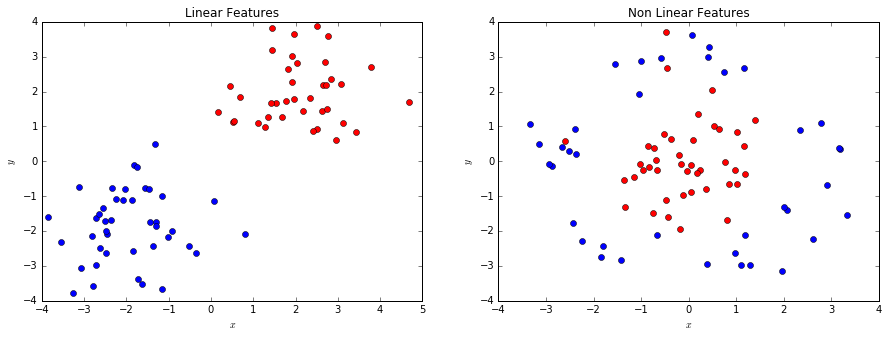

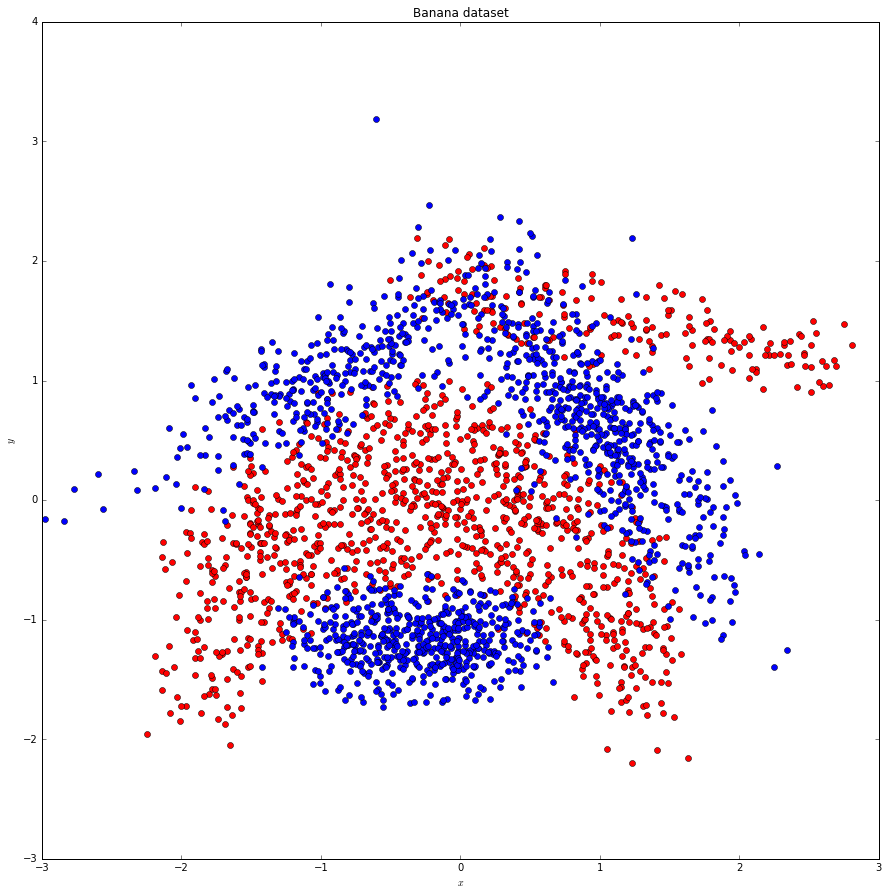

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Linear Features")
plot_binary_data(plt,feats_linear, labels_linear)
plt.subplot(122)
plt.title("Non Linear Features")
plot_binary_data(plt,feats_non_linear, labels_non_linear)

plt.figure(figsize=(15,15))
plt.title("Banana dataset")
plot_binary_data(plt,x_train, y_train)



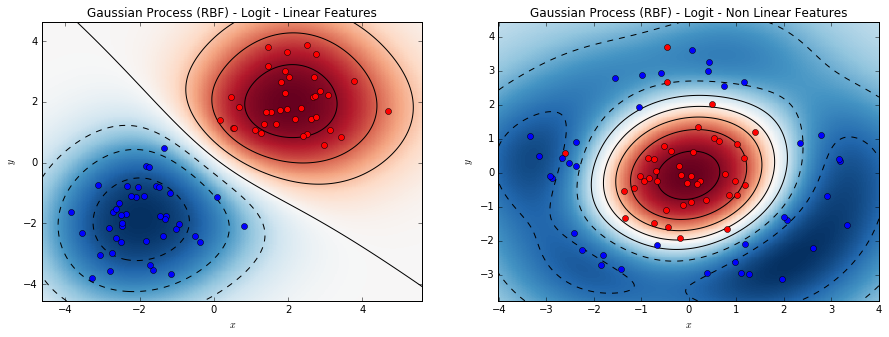

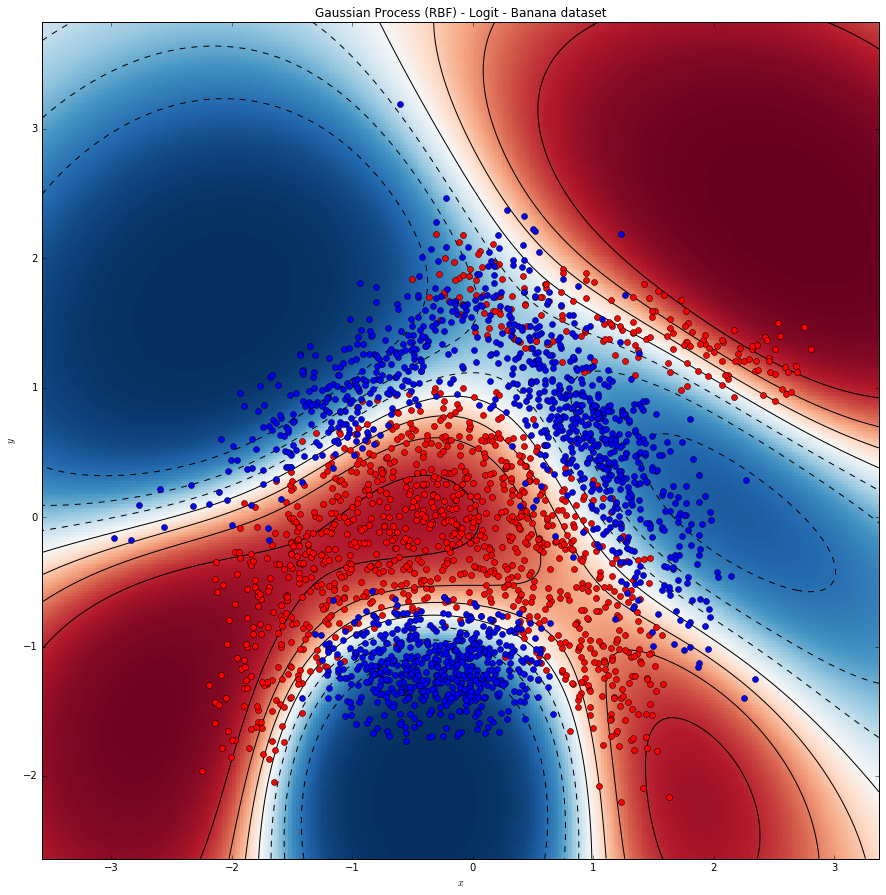

In [7]:
plt.figure(figsize=(15,5))

kernel = GaussianARDSparseKernel(10)
kernel.set_scalar_weights(1.0/np.sqrt(2.0))
# create zero mean function
zero_mean = ZeroMean()
# create logit likelihood model
likelihood = LogitLikelihood()
# specify approximation inference method
inference_method = SingleLaplacianInferenceMethodWithLBFGS


inference_model_linear = inference_method(kernel, shogun_feats_linear, zero_mean, shogun_labels_linear, likelihood)
# create and train GP classifier, which uses Laplace approximation
gaussian_logit_linear = GaussianProcessClassification(inference_model_linear)
gaussian_logit_linear.train()
plt.subplot(121)
plt.title("Gaussian Process (RBF) - Logit - Linear Features")
plot_model(plt,gaussian_logit_linear,feats_linear,labels_linear)


inference_model_non_linear = inference_method(kernel, shogun_feats_non_linear, zero_mean,
                                               shogun_labels_non_linear, likelihood)
gaussian_logit_non_linear = GaussianProcessClassification(inference_model_non_linear)
gaussian_logit_non_linear.train()
plt.subplot(122)
plt.title("Gaussian Process (RBF) - Logit - Non Linear Features")
plot_model(plt,gaussian_logit_non_linear,feats_non_linear,labels_non_linear)


plt.figure(figsize=(15,15))
inference_model_banana = inference_method(kernel, x_train1, zero_mean, y_train1, likelihood)
gaussian_logit_banana = GaussianProcessClassification(inference_model_banana)
gaussian_logit_banana.train()
plt.title("Gaussian Process (RBF) - Logit - Banana dataset")
plot_model(plt,gaussian_logit_banana,x_train,y_train)

In [12]:
def get_inducing(x_train, n_inducing):
    np.random.seed(8)
    x_inducing=[] 
    for idx in xrange( x_train.shape[0]):
        x_f_inducing = np.random.rand(n_inducing)*(x_train[idx,:].max()-x_train[idx,:].min())+x_train[idx,:].min()
        x_inducing.append(x_f_inducing)
    return np.row_stack(x_inducing)

Using 10 inducing points for sparse GP classification and optimizing inducing points

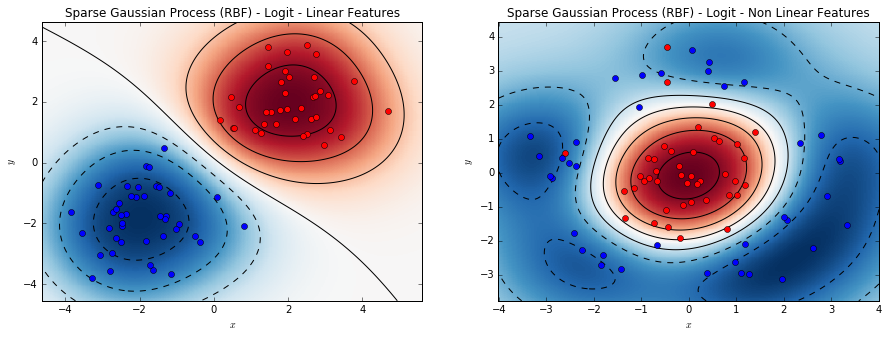

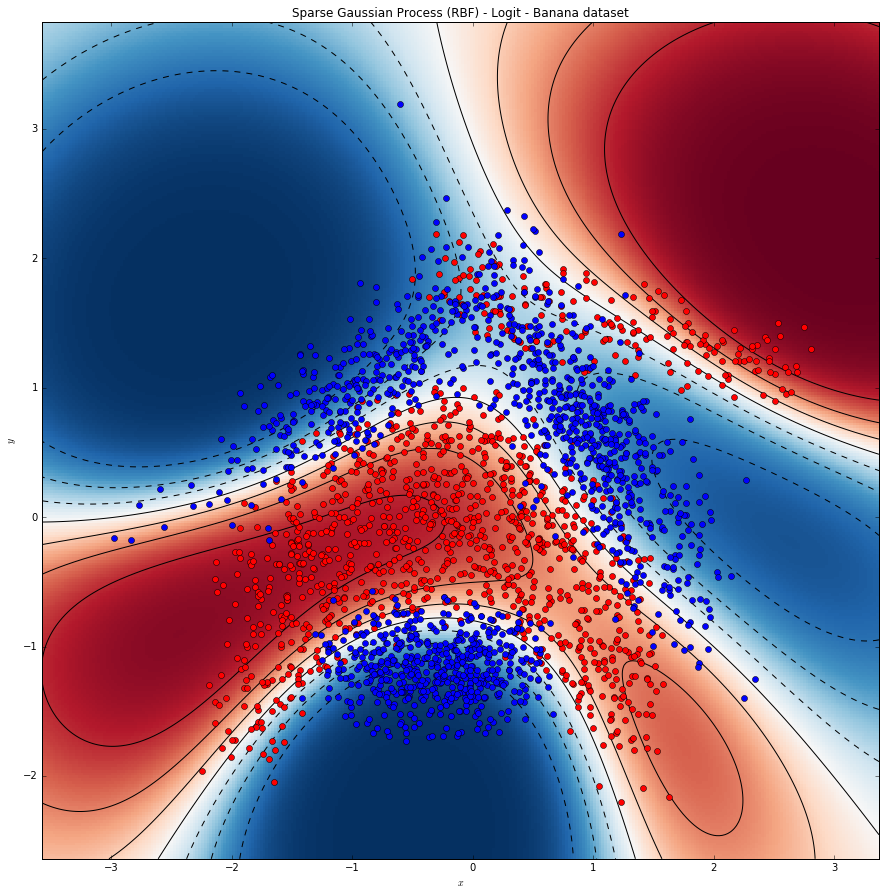

In [13]:
n_inducing=10

plt.figure(figsize=(15,5))

# create logit likelihood model
likelihood = LogitLikelihood()
# specify approximation inference method
inference_method = SingleFITCLaplacianInferenceMethod


shogun_inducing_feats_linear = RealFeatures(get_inducing(feats_linear,n_inducing))
inference_model_linear = inference_method(kernel, shogun_feats_linear, zero_mean, 
                                          shogun_labels_linear, likelihood, shogun_inducing_feats_linear)
inference_model_linear.enable_optimizing_inducing_features(True)
inference_model_linear.set_tolearance_for_inducing_features(1e-3)
inference_model_linear.set_max_iterations_for_inducing_features(20)
gaussian_logit_linear = GaussianProcessClassification(inference_model_linear)
gaussian_logit_linear.train()
plt.subplot(121)
plt.title("Sparse Gaussian Process (RBF) - Logit - Linear Features")
plot_model(plt,gaussian_logit_linear,feats_linear,labels_linear)


shogun_inducing_feats_non_linear= RealFeatures(get_inducing(feats_non_linear,n_inducing))
inference_model_non_linear = inference_method(kernel, shogun_feats_non_linear, zero_mean,
                                               shogun_labels_non_linear, likelihood, shogun_inducing_feats_non_linear)
inference_model_non_linear.enable_optimizing_inducing_features(True)
inference_model_non_linear.set_tolearance_for_inducing_features(1e-3)
inference_model_non_linear.set_max_iterations_for_inducing_features(20)
gaussian_logit_non_linear = GaussianProcessClassification(inference_model_non_linear)
gaussian_logit_non_linear.train()
plt.subplot(122)
plt.title("Sparse Gaussian Process (RBF) - Logit - Non Linear Features")
plot_model(plt,gaussian_logit_non_linear,feats_non_linear,labels_non_linear)


plt.figure(figsize=(15,15))
x_inducing= RealFeatures(get_inducing(x_train,n_inducing))
inference_model_banana = inference_method(kernel, x_train1, zero_mean, y_train1, likelihood, x_inducing)
inference_model_banana.enable_optimizing_inducing_features(True)
inference_model_banana.set_tolearance_for_inducing_features(1e-3)
inference_model_banana.set_max_iterations_for_inducing_features(20)
gaussian_logit_banana = GaussianProcessClassification(inference_model_banana)
gaussian_logit_banana.train()
plt.title("Sparse Gaussian Process (RBF) - Logit - Banana dataset")
plot_model(plt,gaussian_logit_banana,x_train,y_train)

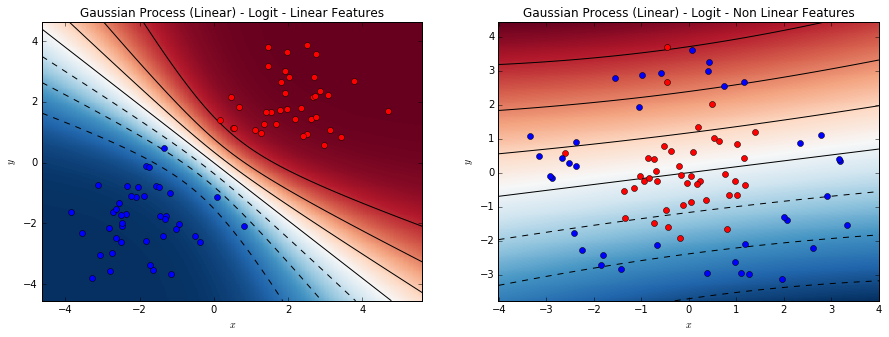

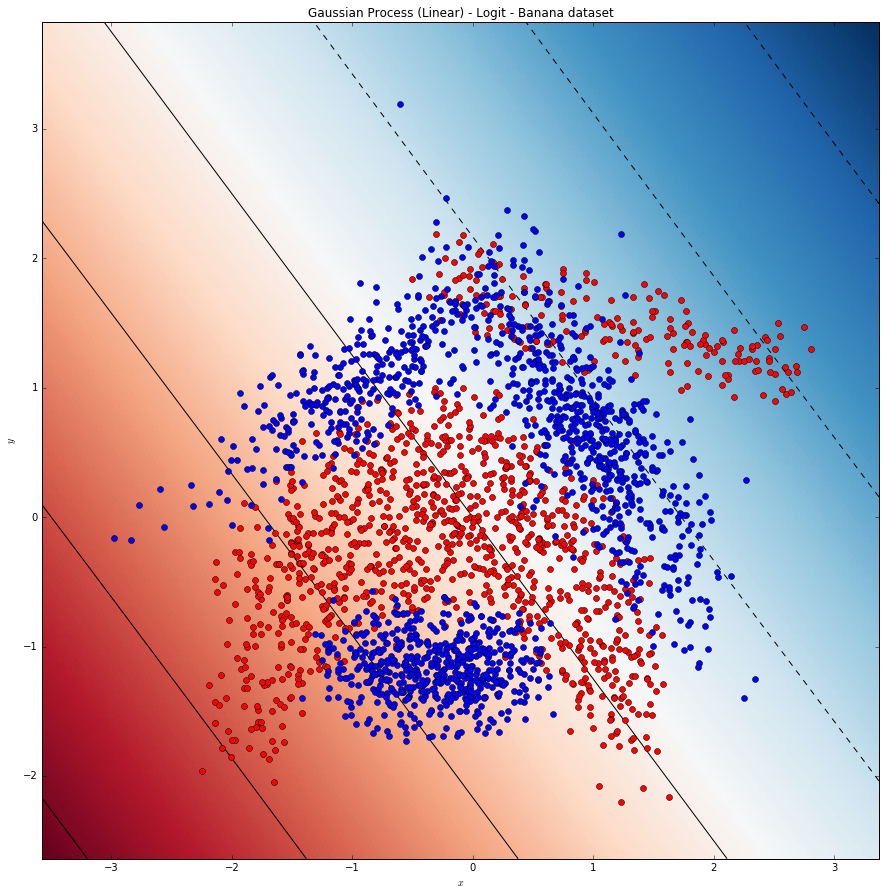

In [8]:
plt.figure(figsize=(15,5))

kernel = LinearKernel()
# create zero mean function
zero_mean = ZeroMean()
# create logit likelihood model
likelihood = LogitLikelihood()
# specify approximation inference method
inference_method = SingleLaplacianInferenceMethodWithLBFGS


inference_model_linear = inference_method(kernel, shogun_feats_linear, zero_mean, shogun_labels_linear, likelihood)
# create and train GP classifier, which uses Laplace approximation
gaussian_logit_linear = GaussianProcessClassification(inference_model_linear)
gaussian_logit_linear.train()
plt.subplot(121)
plt.title("Gaussian Process (Linear) - Logit - Linear Features")
plot_model(plt,gaussian_logit_linear,feats_linear,labels_linear)


inference_model_non_linear = inference_method(kernel, shogun_feats_non_linear, zero_mean,
                                               shogun_labels_non_linear, likelihood)
gaussian_logit_non_linear = GaussianProcessClassification(inference_model_non_linear)
gaussian_logit_non_linear.train()
plt.subplot(122)
plt.title("Gaussian Process (Linear) - Logit - Non Linear Features")
plot_model(plt,gaussian_logit_non_linear,feats_non_linear,labels_non_linear)


plt.figure(figsize=(15,15))
inference_model_banana = inference_method(kernel, x_train1, zero_mean, y_train1, likelihood)
gaussian_logit_banana = GaussianProcessClassification(inference_model_banana)
gaussian_logit_banana.train()
plt.title("Gaussian Process (Linear) - Logit - Banana dataset")
plot_model(plt,gaussian_logit_banana,x_train,y_train)

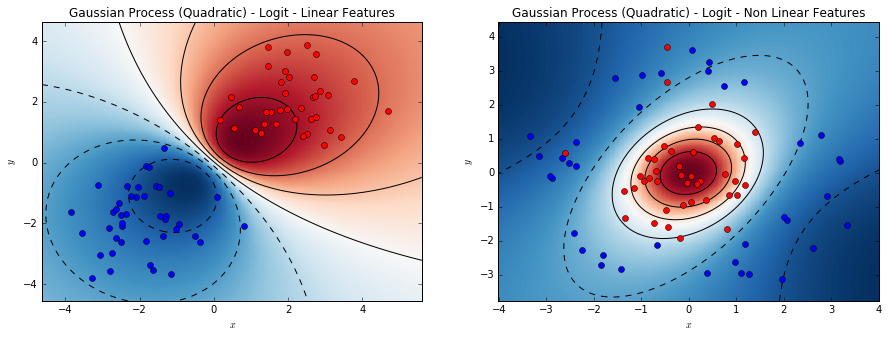

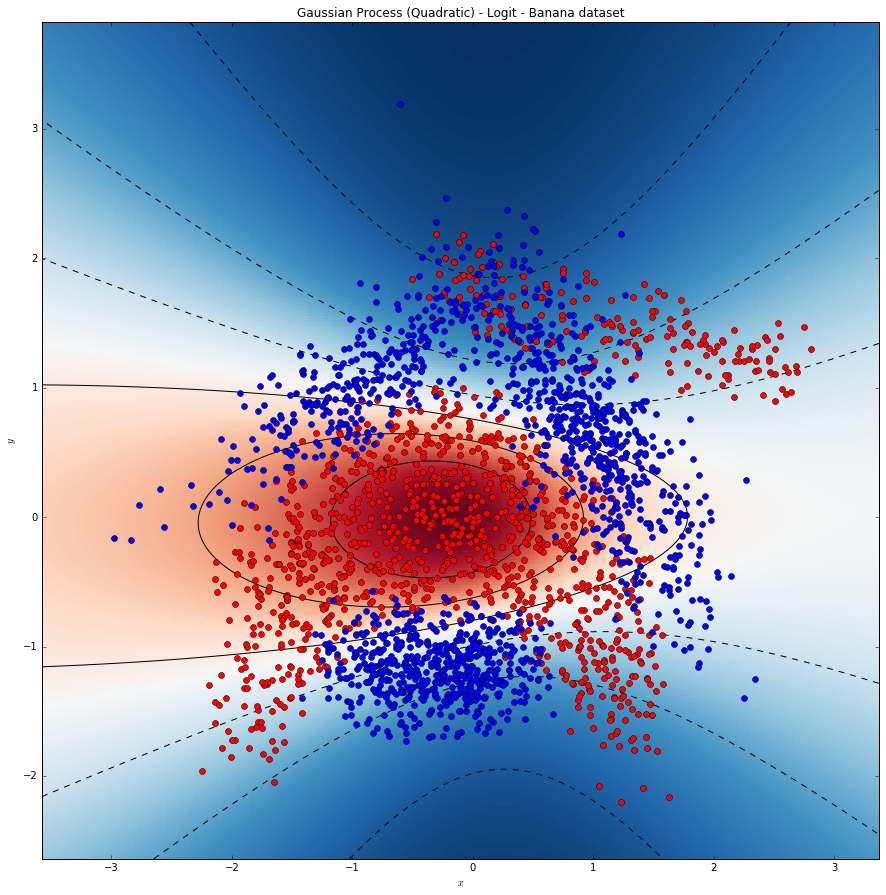

In [33]:
plt.figure(figsize=(15,5))

kernel = PolyKernel(20,2)
# create zero mean function
zero_mean = ZeroMean()
# create logit likelihood model
likelihood = LogitLikelihood()
# specify approximation inference method
inference_method = SingleLaplacianInferenceMethodWithLBFGS


inference_model_linear = inference_method(kernel, shogun_feats_linear, zero_mean, shogun_labels_linear, likelihood)
# create and train GP classifier, which uses Laplace approximation
gaussian_logit_linear = GaussianProcessClassification(inference_model_linear)
gaussian_logit_linear.train()
plt.subplot(121)
plt.title("Gaussian Process (Quadratic) - Logit - Linear Features")
plot_model(plt,gaussian_logit_linear,feats_linear,labels_linear)


inference_model_non_linear = inference_method(kernel, shogun_feats_non_linear, zero_mean,
                                               shogun_labels_non_linear, likelihood)
gaussian_logit_non_linear = GaussianProcessClassification(inference_model_non_linear)
gaussian_logit_non_linear.train()
plt.subplot(122)
plt.title("Gaussian Process (Quadratic) - Logit - Non Linear Features")
plot_model(plt,gaussian_logit_non_linear,feats_non_linear,labels_non_linear)


plt.figure(figsize=(15,15))
inference_model_banana = inference_method(kernel, x_train1, zero_mean, y_train1, likelihood)
gaussian_logit_banana = GaussianProcessClassification(inference_model_banana)
gaussian_logit_banana.train()
plt.title("Gaussian Process (Quadratic) - Logit - Banana dataset")
plot_model(plt,gaussian_logit_banana,x_train,y_train)

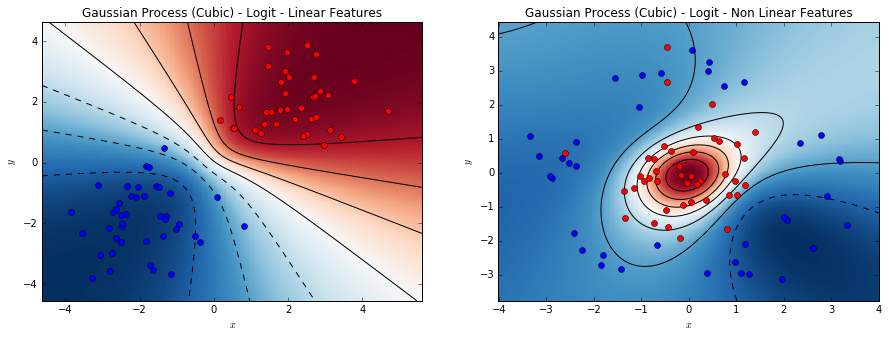

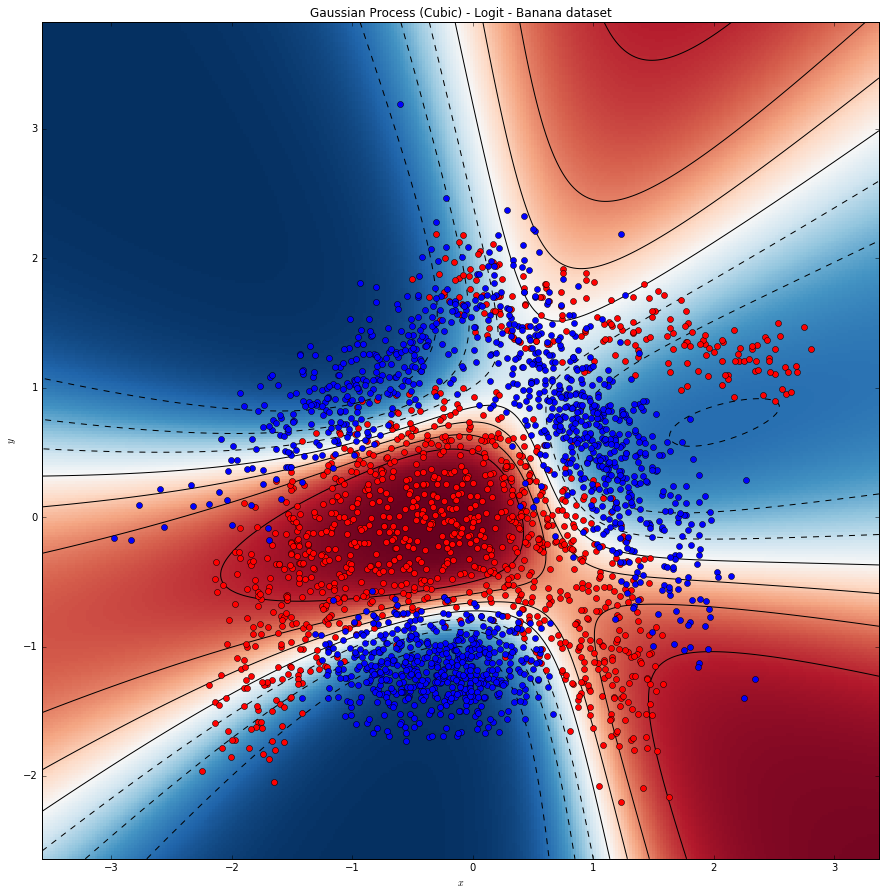

In [35]:
plt.figure(figsize=(15,5))

kernel = PolyKernel(20,3)
# create zero mean function
zero_mean = ZeroMean()
# create logit likelihood model
likelihood = LogitLikelihood()
# specify approximation inference method
inference_method = SingleLaplacianInferenceMethodWithLBFGS


inference_model_linear = inference_method(kernel, shogun_feats_linear, zero_mean, shogun_labels_linear, likelihood)
# create and train GP classifier, which uses Laplace approximation
gaussian_logit_linear = GaussianProcessClassification(inference_model_linear)
gaussian_logit_linear.train()
plt.subplot(121)
plt.title("Gaussian Process (Cubic) - Logit - Linear Features")
plot_model(plt,gaussian_logit_linear,feats_linear,labels_linear)


inference_model_non_linear = inference_method(kernel, shogun_feats_non_linear, zero_mean,
                                               shogun_labels_non_linear, likelihood)
gaussian_logit_non_linear = GaussianProcessClassification(inference_model_non_linear)
gaussian_logit_non_linear.train()
plt.subplot(122)
plt.title("Gaussian Process (Cubic) - Logit - Non Linear Features")
plot_model(plt,gaussian_logit_non_linear,feats_non_linear,labels_non_linear)


plt.figure(figsize=(15,15))
inference_model_banana = inference_method(kernel, x_train1, zero_mean, y_train1, likelihood)
gaussian_logit_banana = GaussianProcessClassification(inference_model_banana)
gaussian_logit_banana.train()
plt.title("Gaussian Process (Cubic) - Logit - Banana dataset")
plot_model(plt,gaussian_logit_banana,x_train,y_train)

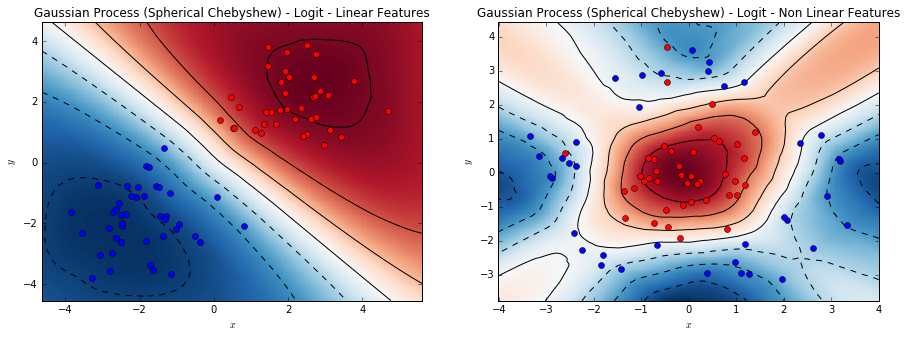

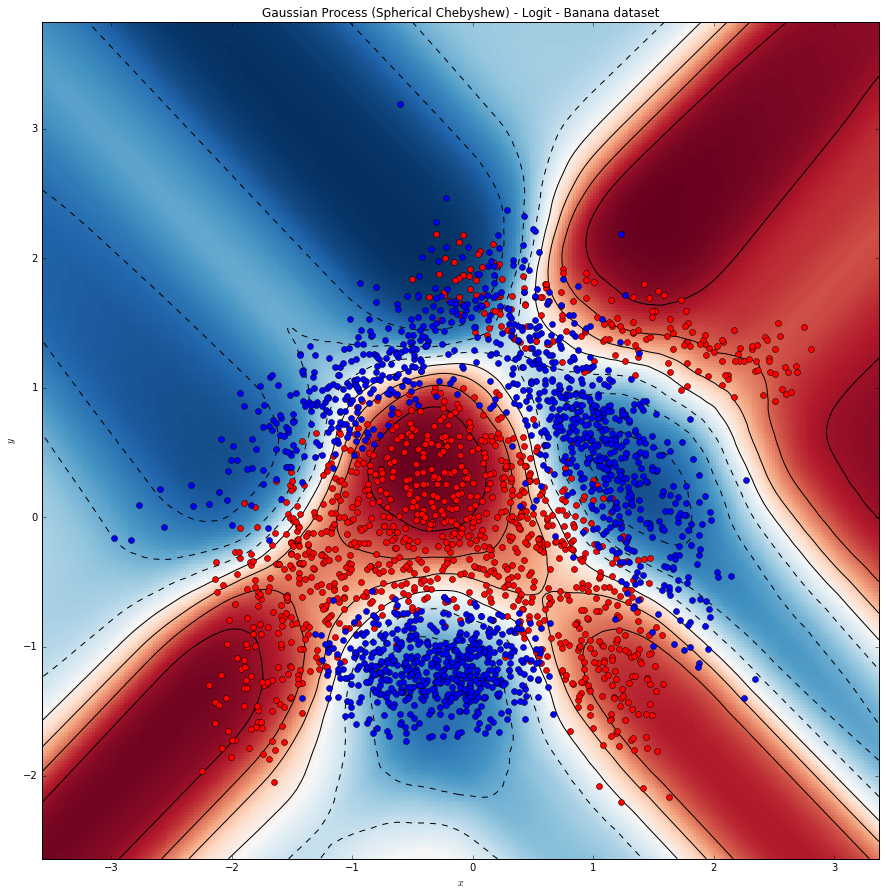

In [38]:
plt.figure(figsize=(15,5))

metric=ChebyshewMetric()
kernel = SphericalKernel(20, 10.0, metric)
# create zero mean function
zero_mean = ZeroMean()
# create logit likelihood model
likelihood = LogitLikelihood()
# specify approximation inference method
inference_method = SingleLaplacianInferenceMethodWithLBFGS


inference_model_linear = inference_method(kernel, shogun_feats_linear, zero_mean, shogun_labels_linear, likelihood)
# create and train GP classifier, which uses Laplace approximation
gaussian_logit_linear = GaussianProcessClassification(inference_model_linear)
gaussian_logit_linear.train()
plt.subplot(121)
plt.title("Gaussian Process (Spherical Chebyshew) - Logit - Linear Features")
plot_model(plt,gaussian_logit_linear,feats_linear,labels_linear)


inference_model_non_linear = inference_method(kernel, shogun_feats_non_linear, zero_mean,
                                               shogun_labels_non_linear, likelihood)
gaussian_logit_non_linear = GaussianProcessClassification(inference_model_non_linear)
gaussian_logit_non_linear.train()
plt.subplot(122)
plt.title("Gaussian Process (Spherical Chebyshew) - Logit - Non Linear Features")
plot_model(plt,gaussian_logit_non_linear,feats_non_linear,labels_non_linear)


plt.figure(figsize=(15,15))
inference_model_banana = inference_method(kernel, x_train1, zero_mean, y_train1, likelihood)
gaussian_logit_banana = GaussianProcessClassification(inference_model_banana)
gaussian_logit_banana.train()
plt.title("Gaussian Process (Spherical Chebyshew) - Logit - Banana dataset")
plot_model(plt,gaussian_logit_banana,x_train,y_train)

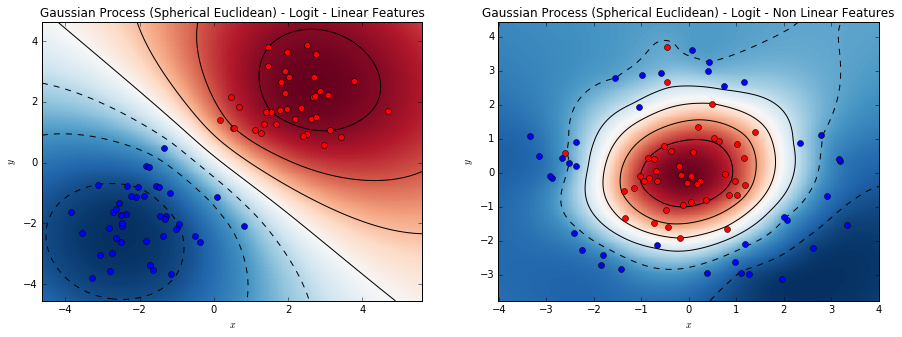

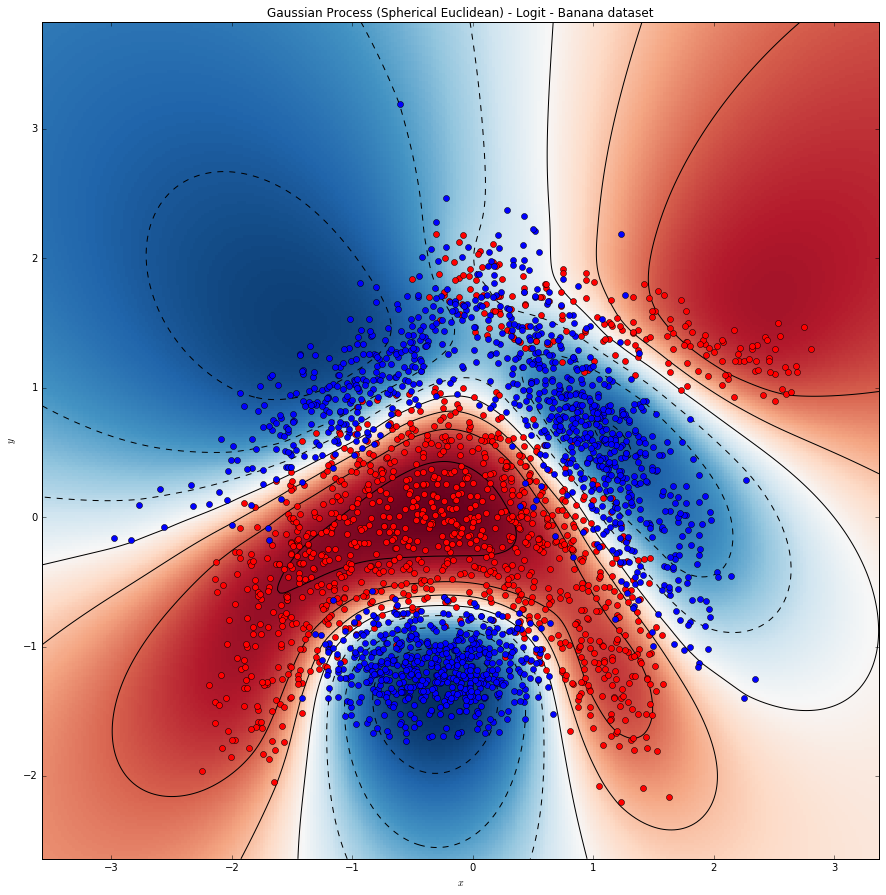

In [8]:
plt.figure(figsize=(15,5))

metric=EuclideanDistance()
kernel = SphericalKernel(20, 10.0, metric)
# create zero mean function
zero_mean = ZeroMean()
# create logit likelihood model
likelihood = LogitLikelihood()
# specify approximation inference method
inference_method = SingleLaplacianInferenceMethodWithLBFGS

inference_model_linear = inference_method(kernel, shogun_feats_linear, zero_mean, shogun_labels_linear, likelihood)
# create and train GP classifier, which uses Laplace approximation
gaussian_logit_linear = GaussianProcessClassification(inference_model_linear)
gaussian_logit_linear.train()
plt.subplot(121)
plt.title("Gaussian Process (Spherical Euclidean) - Logit - Linear Features")
plot_model(plt,gaussian_logit_linear,feats_linear,labels_linear)


inference_model_non_linear = inference_method(kernel, shogun_feats_non_linear, zero_mean,
                                               shogun_labels_non_linear, likelihood)
gaussian_logit_non_linear = GaussianProcessClassification(inference_model_non_linear)
gaussian_logit_non_linear.train()
plt.subplot(122)
plt.title("Gaussian Process (Spherical Euclidean) - Logit - Non Linear Features")
plot_model(plt,gaussian_logit_non_linear,feats_non_linear,labels_non_linear)


plt.figure(figsize=(15,15))
inference_model_banana = inference_method(kernel, x_train1, zero_mean, y_train1, likelihood)
gaussian_logit_banana = GaussianProcessClassification(inference_model_banana)
gaussian_logit_banana.train()
plt.title("Gaussian Process (Spherical Euclidean) - Logit - Banana dataset")
plot_model(plt,gaussian_logit_banana,x_train,y_train)